<a href="https://colab.research.google.com/github/NitinVerma2027/PRML-Apr2025/blob/main/ml_ipynb_files/GaussianNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GaussianNB + PCA (MANUALLY)

Datasets loaded successfully.

Checking for missing values in training data:
0      0
1      0
2      0
3      0
4      0
      ..
780    0
781    0
782    0
783    0
784    0
Length: 785, dtype: int64
No missing values found in training data.

Checking for missing values in testing data:
0      0
1      0
2      0
3      0
4      0
      ..
780    0
781    0
782    0
783    0
784    0
Length: 785, dtype: int64
No missing values found in testing data.

Training data shape: (60000, 784)
Testing data shape: (10000, 784)

PCA transformed training data shape: (60000, 60)
PCA transformed testing data shape: (10000, 60)
Total explained variance by 60 components: 85.26%

Best hyperparameters: {'var_smoothing': np.float64(0.012328467394420685)}
Best cross-validation Accuracy: 87.19%

Test Accuracy with tuned ManualGaussianNB: 88.15%

Confusion Matrix:
[[ 925    0    8    5    0   28    9    4    1    0]
 [   0 1077   16    5    0   10    6    2   18    1]
 [  18    2  871   27   17    9    9  

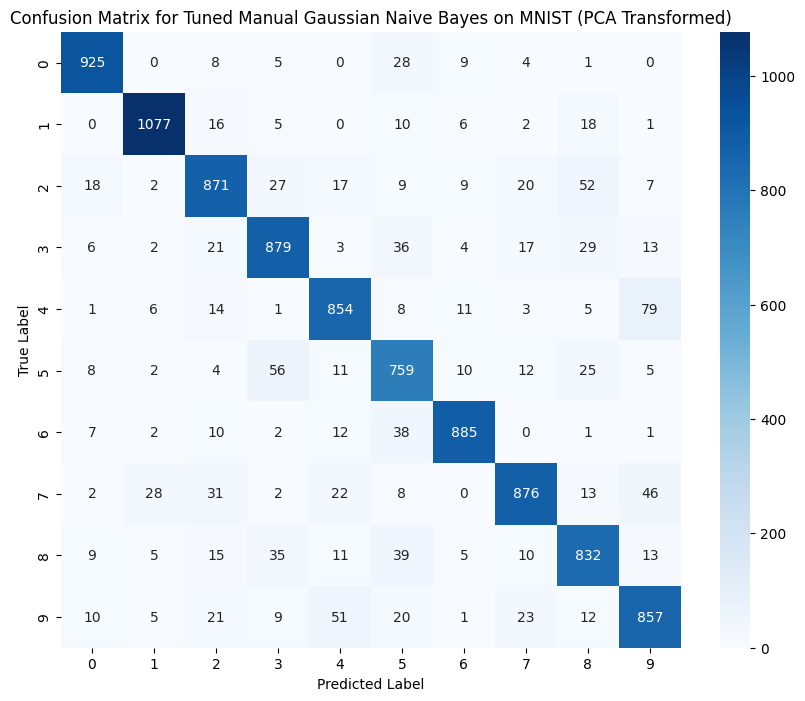

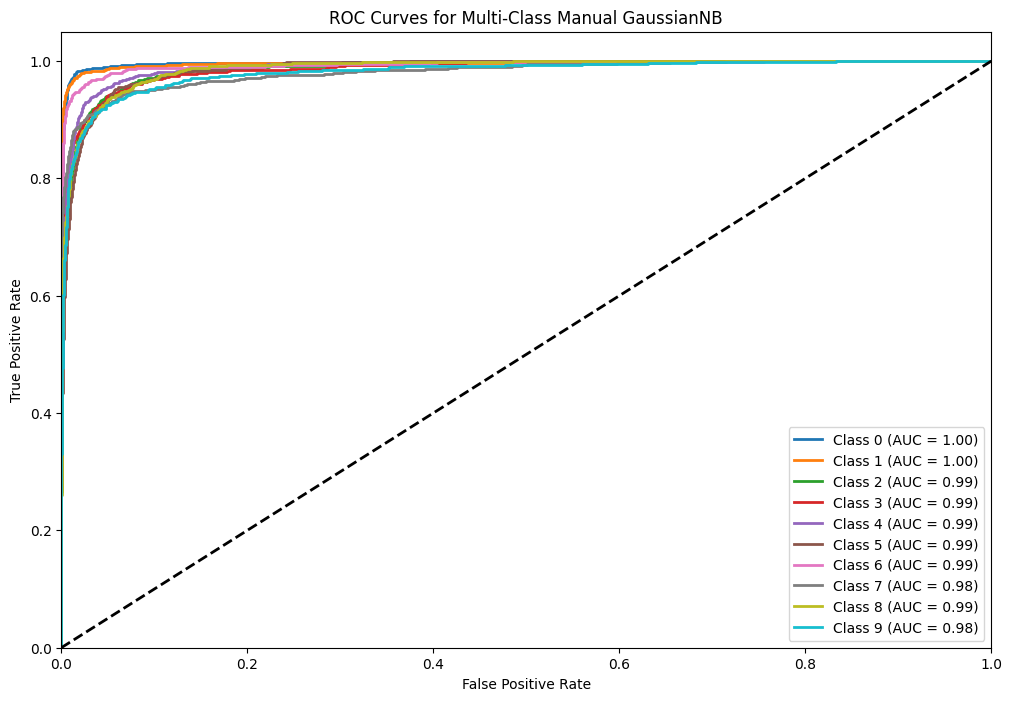

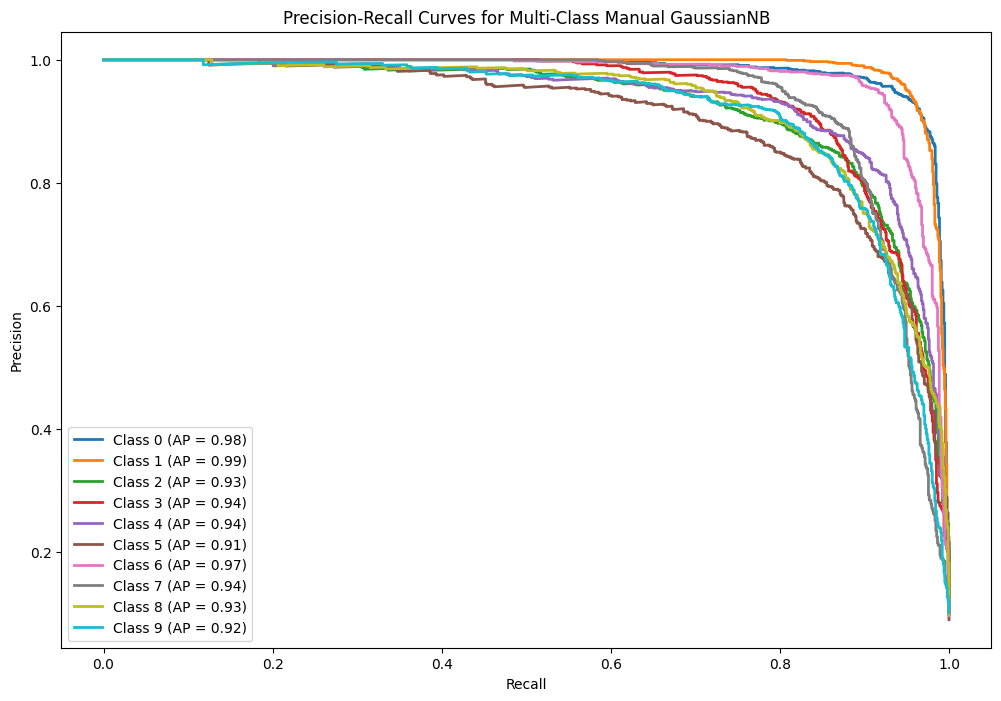

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             classification_report, precision_score,
                             recall_score, f1_score)
from sklearn.model_selection import cross_val_score, GridSearchCV
import random
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# --- Manual PCA Implementation ---
class ManualPCA:
    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        # mean of each feature and center the data
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_
        # covariance matrix (features as columns)
        cov_matrix = np.cov(X_centered, rowvar=False)
        # eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        # Sort eigenvalues and corresponding eigenvectors in descending order
        sorted_idx = np.argsort(eigenvalues)[::-1]
        self.explained_variance_ = eigenvalues[sorted_idx]
        eigenvectors = eigenvectors[:, sorted_idx]
        # Select first n_components eigenvectors
        self.components_ = eigenvectors[:, :self.n_components]
        # Compute explained variance ratio
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio_ = self.explained_variance_[:self.n_components] / total_variance
        return self

    def transform(self, X):
        X_centered = X - self.mean_
        return np.dot(X_centered, self.components_)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# --- Manual Gaussian Naive Bayes Implementation ---
class ManualGaussianNB:
    def __init__(self, var_smoothing=1e-9):
        self.var_smoothing = var_smoothing

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.means_ = {}
        self.vars_ = {}
        self.priors_ = {}
        for cls in self.classes_:
            X_cls = X[y == cls]
            self.means_[cls] = np.mean(X_cls, axis=0)
            self.vars_[cls] = np.var(X_cls, axis=0) + self.var_smoothing
            self.priors_[cls] = X_cls.shape[0] / X.shape[0]
        return self

    def predict_proba(self, X):
        probs = []
        # For each class, compute log probability for each sample
        for cls in self.classes_:
            mean = self.means_[cls]
            var = self.vars_[cls]
            # Using Gaussian probability density function in log space
            log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * var))
            log_likelihood += -0.5 * np.sum(((X - mean) ** 2) / var, axis=1)
            log_prior = np.log(self.priors_[cls])
            probs.append(log_likelihood + log_prior)
        probs = np.vstack(probs).T  # (n_samples, n_classes)
        # Convert log probabilities to probabilities using softmax for numerical stability
        max_log = np.max(probs, axis=1, keepdims=True)
        probs_exp = np.exp(probs - max_log)
        proba = probs_exp / np.sum(probs_exp, axis=1, keepdims=True)
        return proba

    def predict(self, X):
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]

    # For compatibility with GridSearchCV
    def get_params(self, deep=True):
        return {"var_smoothing": self.var_smoothing}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

# Functions for Data Loading and Preprocessing
def load_data(train_path, test_path):
    try:
        train_data = pd.read_csv(train_path, header=None)
        test_data = pd.read_csv(test_path, header=None)
        print("Datasets loaded successfully.")
        return train_data, test_data
    except FileNotFoundError as e:
        print(f"Error: CSV files not found. Ensure '{train_path}' and '{test_path}' exist in your working directory.")
        raise e

def check_and_impute(data, name="Data"):
    print(f"\nChecking for missing values in {name}:")
    missing_counts = data.isnull().sum()
    print(missing_counts)
    if data.isnull().values.any():
        data.fillna(data.mean(), inplace=True)
        print(f"Missing values in {name} filled with column means.")
    else:
        print(f"No missing values found in {name}.")
    return data

# Load and Preprocess the Data
train_data, test_data = load_data("mnist_train.csv", "mnist_test.csv")
train_data = check_and_impute(train_data, "training data")
test_data = check_and_impute(test_data, "testing data")

# The first column is assumed to be the label.
label_column = train_data.columns[0]
X_train = train_data.drop(label_column, axis=1)
y_train = train_data[label_column]
X_test = test_data.drop(label_column, axis=1)
y_test = test_data[label_column]

print("\nTraining data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

# Normalize pixel values (from 0-255 to 0-1)
scaling_factor = 255.0
X_train_norm = X_train / scaling_factor
X_test_norm = X_test / scaling_factor

# --- Apply Manual PCA to reduce dimensionality ---
pca_components = 60
pca = ManualPCA(n_components=pca_components)
X_train_pca = pca.fit_transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

print("\nPCA transformed training data shape:", X_train_pca.shape)
print("PCA transformed testing data shape:", X_test_pca.shape)
explained_variance = np.sum(pca.explained_variance_ratio_)
print("Total explained variance by {} components: {:.2f}%".format(pca_components, explained_variance * 100))

# Hyperparameter Tuning with GridSearchCV for ManualGaussianNB
param_grid = {"var_smoothing": np.logspace(-10, -1, 100)}
grid_search = GridSearchCV(estimator=ManualGaussianNB(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)
print("\nBest hyperparameters:", grid_search.best_params_)
print("Best cross-validation Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

# Use best estimator from grid search for further predictions
best_gnb = grid_search.best_estimator_

# Evaluate Tuned Model on the Test Set
y_pred = best_gnb.predict(X_test_pca)

# Overall Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy with tuned ManualGaussianNB: {:.2f}%".format(accuracy * 100))

# Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

# Additional evaluation metrics (macro-averaged)
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print("Macro-Average Precision: {:.2f}".format(precision_macro))
print("Macro-Average Recall: {:.2f}".format(recall_macro))
print("Macro-Average F1 Score: {:.2f}".format(f1_macro))

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix for Tuned Manual Gaussian Naive Bayes on MNIST (PCA Transformed)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Compute predicted probabilities for each class using the tuned model
y_prob = best_gnb.predict_proba(X_test_pca)
n_classes = 10

# Binarize the true labels for multi-class evaluation (one-hot encoding)
y_test_bin = np.eye(n_classes)[y_test]

# Initialize dictionaries to store metrics for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
precision_dict = dict()
recall_dict = dict()
average_precision = dict()

# Compute ROC curve and Precision-Recall curve for each class
for i in range(n_classes):
    # ROC curve and ROC AUC
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Precision-Recall curve and Average Precision
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_prob[:, i])

# Plot ROC curves for each class
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class Manual GaussianNB')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curves for each class
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    plt.plot(recall_dict[i], precision_dict[i], lw=2, label=f'Class {i} (AP = {average_precision[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Multi-Class Manual GaussianNB')
plt.legend(loc="lower left")
plt.show()


#Accuracy per Class Bar Chart

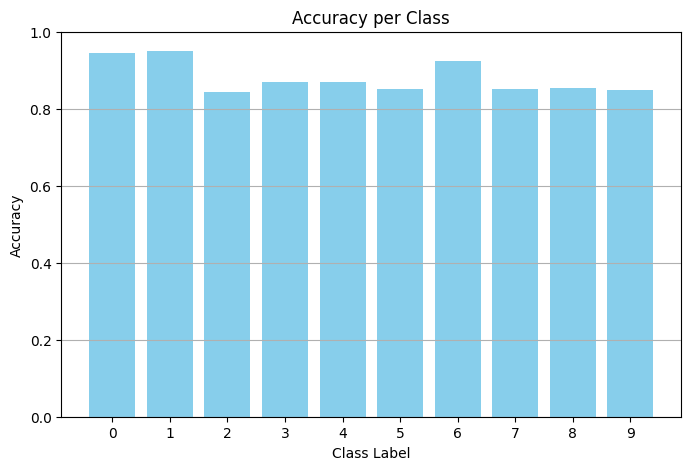

In [17]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(8, 5))
plt.bar(range(10), class_accuracy, color="skyblue")
plt.xlabel("Class Label")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Accuracy per Class")
plt.xticks(range(10))
plt.grid(axis="y")
plt.show()

#Explained Variance vs. Number of PCA Components

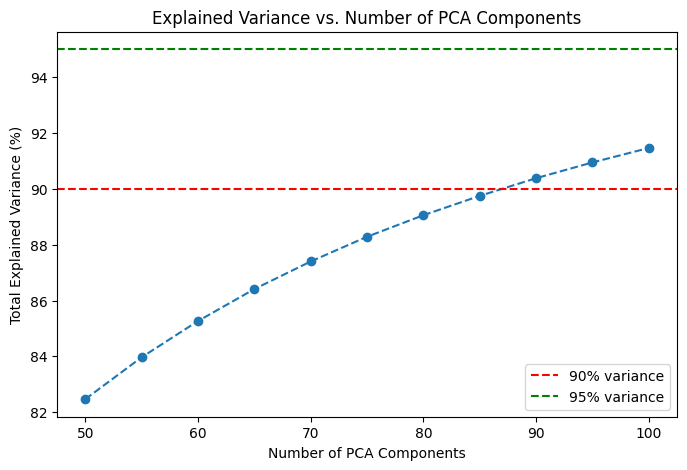

In [18]:
explained_variance_ratios = []
num_components_list = list(range(50, 101, 5))  # Check from 50 to 100 components in steps of 5

for n in num_components_list:
    pca = ManualPCA(n_components=n)
    pca.fit(X_train_norm)
    explained_variance_ratios.append(np.sum(pca.explained_variance_ratio_))

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(num_components_list, np.array(explained_variance_ratios) * 100, marker='o', linestyle='--')
plt.xlabel('Number of PCA Components')
plt.ylabel('Total Explained Variance (%)')
plt.title('Explained Variance vs. Number of PCA Components')
plt.axhline(y=90, color='r', linestyle='--', label="90% variance")
plt.axhline(y=95, color='g', linestyle='--', label="95% variance")
plt.legend()
plt.show()


#Cross-Validation to Find Best PCA Components

In [19]:
from sklearn.model_selection import cross_val_score

best_accuracy = 0
best_n_components = None

for n in num_components_list:
    pca = ManualPCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_norm)

    # Apply Naive Bayes and check accuracy
    gnb = ManualGaussianNB()
    scores = cross_val_score(gnb, X_train_pca, y_train, cv=5, scoring='accuracy')
    mean_accuracy = scores.mean()

    print(f"PCA Components: {n}, CV Accuracy: {mean_accuracy:.4f}")

    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_n_components = n

print(f"\nBest PCA Components: {best_n_components}, Best Accuracy: {best_accuracy:.4f}")


PCA Components: 50, CV Accuracy: 0.8688
PCA Components: 55, CV Accuracy: 0.8698
PCA Components: 60, CV Accuracy: 0.8708
PCA Components: 65, CV Accuracy: 0.8720
PCA Components: 70, CV Accuracy: 0.8716
PCA Components: 75, CV Accuracy: 0.8717
PCA Components: 80, CV Accuracy: 0.8697
PCA Components: 85, CV Accuracy: 0.8694
PCA Components: 90, CV Accuracy: 0.8689
PCA Components: 95, CV Accuracy: 0.8685
PCA Components: 100, CV Accuracy: 0.8663

Best PCA Components: 65, Best Accuracy: 0.8720


#Cost Function Graph

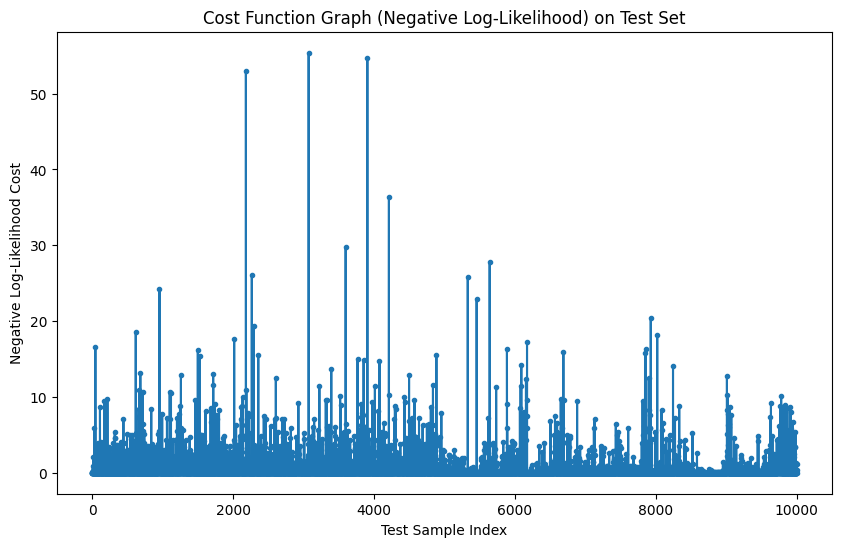

In [18]:
# For each test sample, the cost is -log(probability of the true class).
cost_values = []
for i in range(len(y_test)):
    true_class = y_test.iloc[i]
    prob_true = y_prob[i, true_class]
    cost = -np.log(prob_true)
    cost_values.append(cost)

plt.figure(figsize=(10, 6))
plt.plot(cost_values, marker='o', linestyle='-', markersize=3)
plt.xlabel("Test Sample Index")
plt.ylabel("Negative Log-Likelihood Cost")
plt.title("Cost Function Graph (Negative Log-Likelihood) on Test Set")
plt.show()

#Sample Predictions Display

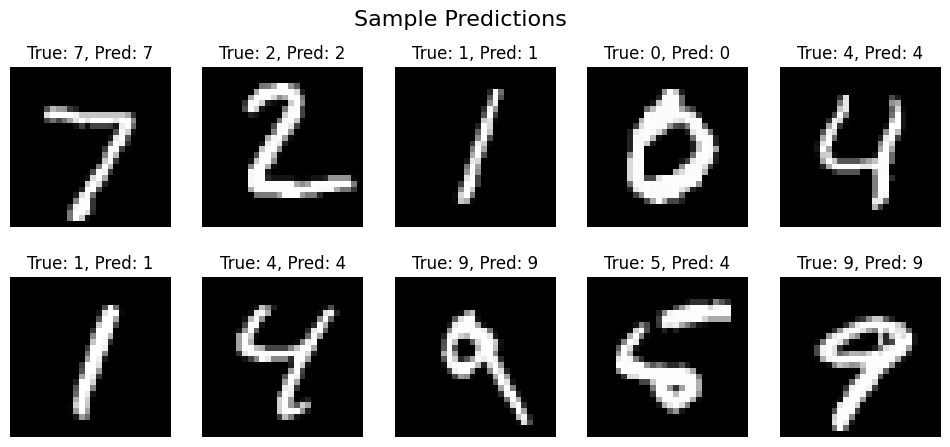

In [16]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Sample Predictions", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test.iloc[i].values.reshape(28, 28), cmap="gray")
    ax.set_title(f"True: {y_test.iloc[i]}, Pred: {y_pred[i]}")
    ax.axis("off")

plt.show()